## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [7]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('..')
import models_mae

### Define utils

In [8]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

In [9]:
from pathlib import Path
from PIL import Image
import cv2

In [10]:
## nuclei images list:

#nuclei_list = list(Path('/data2/image_data_noncom/nuclei_DSB2018/stage1_train/').rglob('*/images/*.png'))

image_list = list(Path('/data2/akurniko/ViTissue/data/orion/tile_256_png/train/CD31/').rglob('*.png'))

In [30]:
img = cv2.imread(str(image_list[2]))#, cv2.IMREAD_UNCHANGED)
#img = Image.open(image_list[2]).load()
#tile_x = 100
#tile_y = 100
#img = 0
#while np.max(img) < 0.7:
#    step = 20
#img = img_base[tile_x:(tile_x+40),tile_y:(tile_y+40),0:3]
#img = np.array(Image.fromarray(img).resize((224, 224)))
#img = img/255.
#    tile_x += step
#    tile_y += step

img = np.array(Image.fromarray(img).resize((224, 224)))
img = img/255.
img.shape


(224, 224, 3)

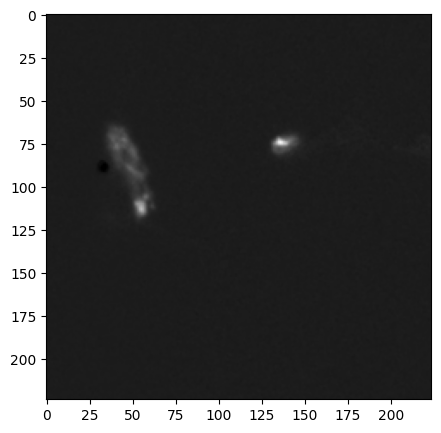

In [31]:
plt.imshow(img)

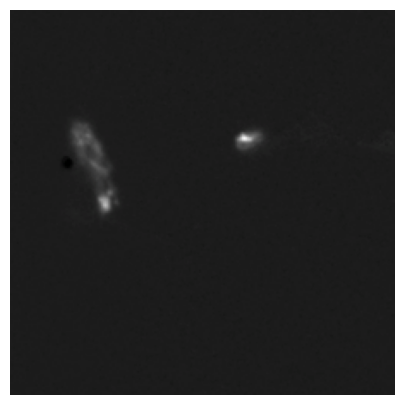

In [32]:
# load an image
#img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
#img = Image.open(requests.get(img_url, stream=True).raw)
#img = img.resize((224, 224))
#img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [ ]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


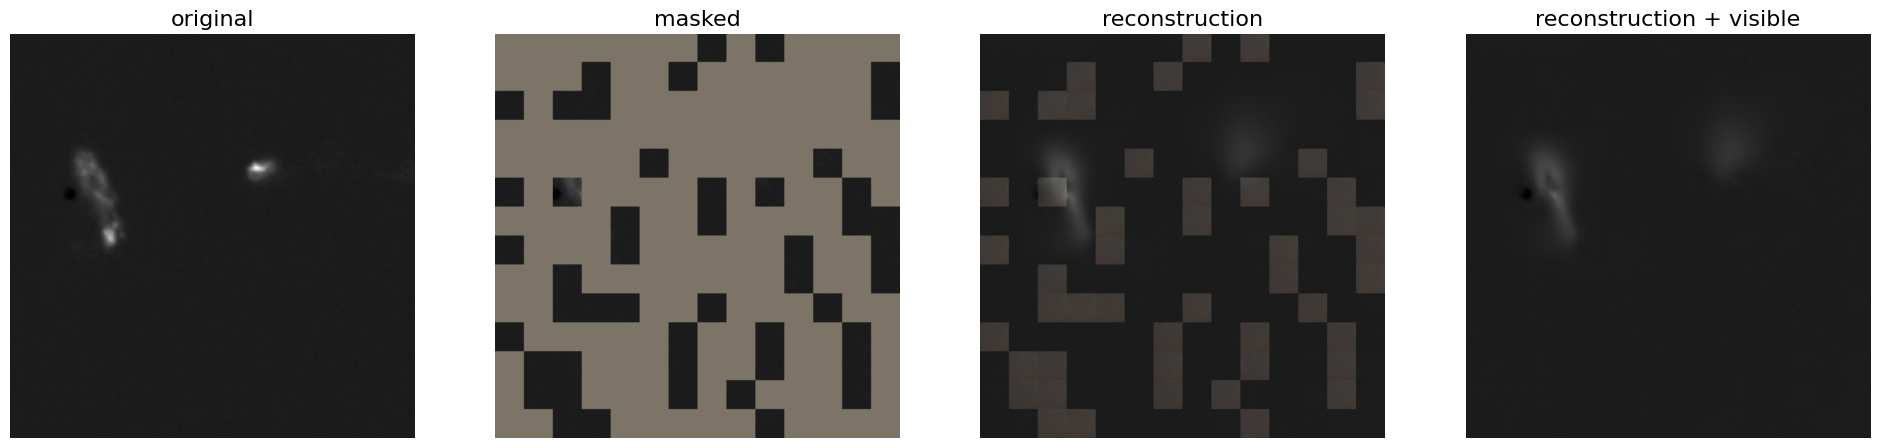

In [33]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [34]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_mae.norm.register_forward_hook(get_activation('norm'))

In [35]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

# run MAE
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)
y = model_mae.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()

embedding = activation['decoder_embed'].detach().cpu()

KeyError: 'decoder_embed'

In [ ]:
x = torch.tensor(img)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

latent, mask, ids_restore = model_mae.forward_encoder(x.float(), 0.0)

latent = latent.detach().cpu()

In [ ]:
x.shape

torch.Size([1, 3, 224, 224])

In [41]:
latent.shape

torch.Size([1, 197, 1024])

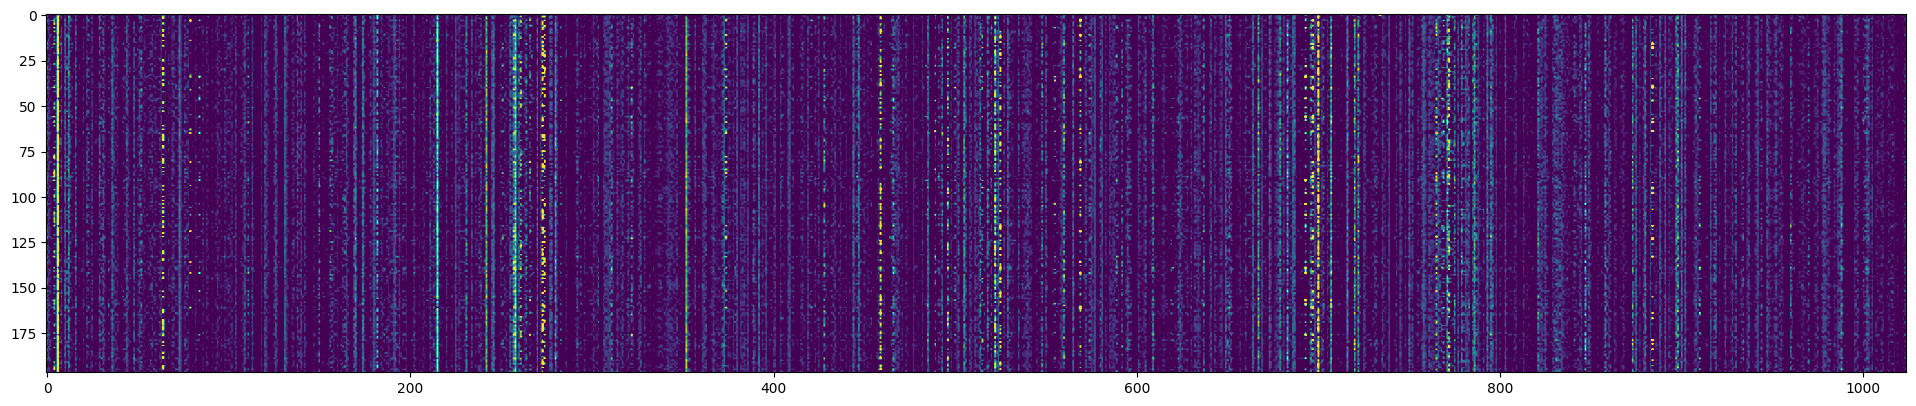

In [42]:
plt.imshow(latent[0,:,:], vmin = 0, vmax = 1)

In [35]:
model_mae

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=1024, out_features=

In [34]:
embedding.shape

torch.Size([1, 50, 512])

In [ ]:
embedding

In [31]:
#model_mae

In [ ]:
# visualize the mask
mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, model_mae.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)

# masked image
im_masked = x * (1 - mask)

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 4, 1)
show_image(x[0], "original")

plt.subplot(1, 4, 2)
show_image(im_masked[0], "masked")

plt.subplot(1, 4, 3)
show_image(y[0], "reconstruction")

plt.subplot(1, 4, 4)
show_image(im_paste[0], "reconstruction + visible")

plt.show()

### Load another pre-trained MAE model

In [104]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


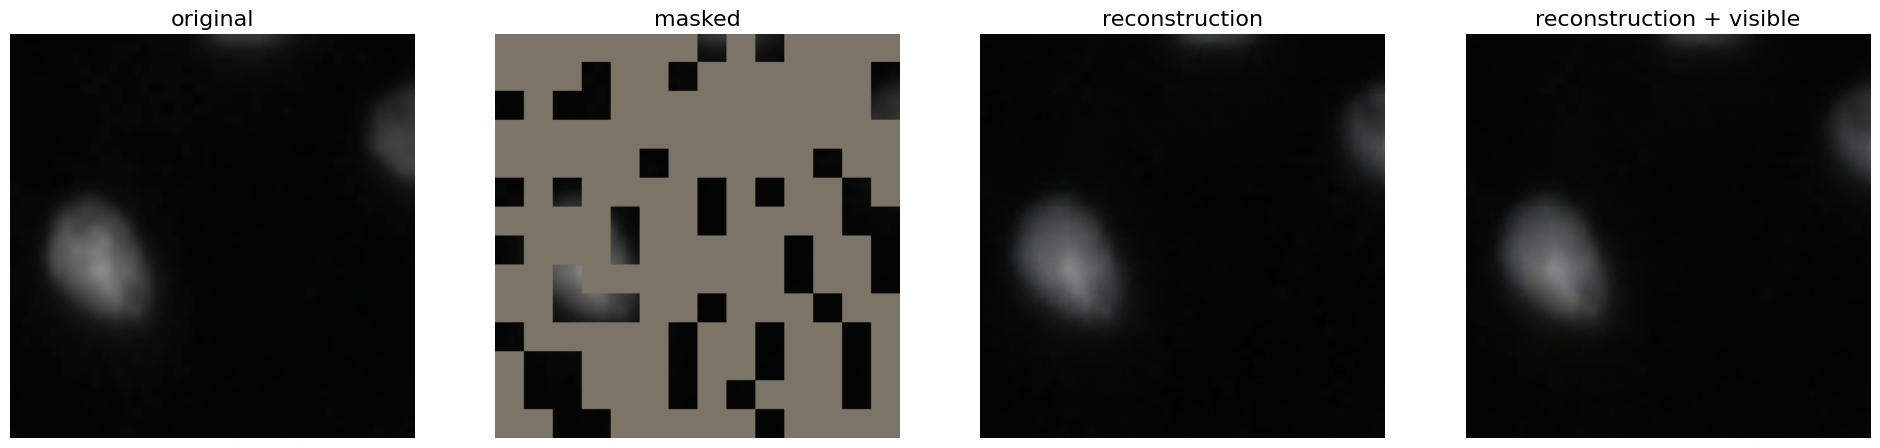

In [105]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

In [106]:
## now lets extract the features from these models